In [1]:
!python --version
!pip3 install torch==1.13.1 torchvision==0.14.1 diffusers==0.18.2 \
scikit-image==0.19.3 scikit-video==1.1.11 \
pygame==2.1.2 pymunk==6.2.1 gym==0.26.2 shapely==1.8.4 \
&> /dev/null # Mute output for cleaner logs

!pip install zarr==2.12.0
!pip install numcodecs==0.10.2
!pip install scikit-video==1.1.11
!pip install torch_optimizer
!pip install numpy==1.25.2
!pip install pyvirtualdisplay
!pip install pymunk==6.2.1
!pip install torch-ema

# Setup Vulkan for ManiSkill on Colab
!sudo mkdir -p /usr/share/vulkan/icd.d
!sudo mkdir -p /usr/share/glvnd/egl_vendor.d
!wget -q https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/nvidia_icd.json
!wget -q https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/10_nvidia.json
!sudo mv nvidia_icd.json /usr/share/vulkan/icd.d/
!sudo mv 10_nvidia.json /usr/share/glvnd/egl_vendor.d/10_nvidia.json
!sudo apt-get update
!sudo apt-get install -y --no-install-recommends libvulkan-dev

# Install ManiSkill dependencies
!pip install -U "mani_skill[dev]" tyro
# !pip install mani-skill2

Python 3.11.12
  Using cached pymunk-6.2.1.zip (7.1 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pymunk: filename=pymunk-6.2.1-cp311-cp311-linux_x86_64.whl size=801777 sha256=d8569fffe6489bffa52b881ac7f74913f6950d3ad8df9636694e341cf1f3a856
  Stored in directory: /root/.cache/pip/wheels/16/23/6d/2e713157384d80a5b142e50188d3707f1146d0e3231a4f2157
Successfully built pymunk
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,607 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubunt

In [2]:
# start virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [3]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import zarr
import gym
from diffusers import DDPMScheduler
from torch.utils.data import DataLoader
import collections
from tqdm import tqdm
from transformers import get_scheduler
import os
import gdown
import math
from IPython.display import Video
import skvideo.io
import pygame
import pymunk
from pymunk.vec2d import Vec2d
from pymunk.space_debug_draw_options import SpaceDebugColor
from typing import Tuple, Sequence, Dict, Union, Optional, Callable

import cv2
import shapely.geometry as sg
import shapely.affinity as st
# from torch_ema import ExponentialMovingAverage as EMAModel
from diffusers.training_utils import EMAModel

/usr/local/lib/python3.11/dist-packages/skvideo/utils/stpyr.py:2: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  import scipy.misc as sc
/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packag

In [23]:
#@markdown ### **Environment**
#@markdown Defines a PyMunk-based Push-T environment `PushTEnv`.
#@markdown And it's subclass `PushTImageEnv`.
#@markdown
#@markdown **Goal**: push the gray T-block into the green area.
#@markdown
#@markdown Adapted from [Implicit Behavior Cloning](https://implicitbc.github.io/)


positive_y_is_up: bool = False
"""Make increasing values of y point upwards.

When True::

    y
    ^
    |      . (3, 3)
    |
    |   . (2, 2)
    |
    +------ > x

When False::

    +------ > x
    |
    |   . (2, 2)
    |
    |      . (3, 3)
    v
    y

"""

def to_pygame(p: Tuple[float, float], surface: pygame.Surface) -> Tuple[int, int]:
    """Convenience method to convert pymunk coordinates to pygame surface
    local coordinates.

    Note that in case positive_y_is_up is False, this function wont actually do
    anything except converting the point to integers.
    """
    if positive_y_is_up:
        return round(p[0]), surface.get_height() - round(p[1])
    else:
        return round(p[0]), round(p[1])


def light_color(color: SpaceDebugColor):
    color = np.minimum(1.2 * np.float32([color.r, color.g, color.b, color.a]), np.float32([255]))
    color = SpaceDebugColor(r=color[0], g=color[1], b=color[2], a=color[3])
    return color

class DrawOptions(pymunk.SpaceDebugDrawOptions):
    def __init__(self, surface: pygame.Surface) -> None:
        """Draw a pymunk.Space on a pygame.Surface object.

        Typical usage::

        >>> import pymunk
        >>> surface = pygame.Surface((10,10))
        >>> space = pymunk.Space()
        >>> options = pymunk.pygame_util.DrawOptions(surface)
        >>> space.debug_draw(options)

        You can control the color of a shape by setting shape.color to the color
        you want it drawn in::

        >>> c = pymunk.Circle(None, 10)
        >>> c.color = pygame.Color("pink")

        See pygame_util.demo.py for a full example

        Since pygame uses a coordiante system where y points down (in contrast
        to many other cases), you either have to make the physics simulation
        with Pymunk also behave in that way, or flip everything when you draw.

        The easiest is probably to just make the simulation behave the same
        way as Pygame does. In that way all coordinates used are in the same
        orientation and easy to reason about::

        >>> space = pymunk.Space()
        >>> space.gravity = (0, -1000)
        >>> body = pymunk.Body()
        >>> body.position = (0, 0) # will be positioned in the top left corner
        >>> space.debug_draw(options)

        To flip the drawing its possible to set the module property
        :py:data:`positive_y_is_up` to True. Then the pygame drawing will flip
        the simulation upside down before drawing::

        >>> positive_y_is_up = True
        >>> body = pymunk.Body()
        >>> body.position = (0, 0)
        >>> # Body will be position in bottom left corner

        :Parameters:
                surface : pygame.Surface
                    Surface that the objects will be drawn on
        """
        self.surface = surface
        super(DrawOptions, self).__init__()

    def draw_circle(
        self,
        pos: Vec2d,
        angle: float,
        radius: float,
        outline_color: SpaceDebugColor,
        fill_color: SpaceDebugColor,
    ) -> None:
        p = to_pygame(pos, self.surface)

        pygame.draw.circle(self.surface, fill_color.as_int(), p, round(radius), 0)
        pygame.draw.circle(self.surface, light_color(fill_color).as_int(), p, round(radius-4), 0)

        circle_edge = pos + Vec2d(radius, 0).rotated(angle)
        p2 = to_pygame(circle_edge, self.surface)
        line_r = 2 if radius > 20 else 1
        # pygame.draw.lines(self.surface, outline_color.as_int(), False, [p, p2], line_r)

    def draw_segment(self, a: Vec2d, b: Vec2d, color: SpaceDebugColor) -> None:
        p1 = to_pygame(a, self.surface)
        p2 = to_pygame(b, self.surface)

        pygame.draw.aalines(self.surface, color.as_int(), False, [p1, p2])

    def draw_fat_segment(
        self,
        a: Tuple[float, float],
        b: Tuple[float, float],
        radius: float,
        outline_color: SpaceDebugColor,
        fill_color: SpaceDebugColor,
    ) -> None:
        p1 = to_pygame(a, self.surface)
        p2 = to_pygame(b, self.surface)

        r = round(max(1, radius * 2))
        pygame.draw.lines(self.surface, fill_color.as_int(), False, [p1, p2], r)
        if r > 2:
            orthog = [abs(p2[1] - p1[1]), abs(p2[0] - p1[0])]
            if orthog[0] == 0 and orthog[1] == 0:
                return
            scale = radius / (orthog[0] * orthog[0] + orthog[1] * orthog[1]) ** 0.5
            orthog[0] = round(orthog[0] * scale)
            orthog[1] = round(orthog[1] * scale)
            points = [
                (p1[0] - orthog[0], p1[1] - orthog[1]),
                (p1[0] + orthog[0], p1[1] + orthog[1]),
                (p2[0] + orthog[0], p2[1] + orthog[1]),
                (p2[0] - orthog[0], p2[1] - orthog[1]),
            ]
            pygame.draw.polygon(self.surface, fill_color.as_int(), points)
            pygame.draw.circle(
                self.surface,
                fill_color.as_int(),
                (round(p1[0]), round(p1[1])),
                round(radius),
            )
            pygame.draw.circle(
                self.surface,
                fill_color.as_int(),
                (round(p2[0]), round(p2[1])),
                round(radius),
            )

    def draw_polygon(
        self,
        verts: Sequence[Tuple[float, float]],
        radius: float,
        outline_color: SpaceDebugColor,
        fill_color: SpaceDebugColor,
    ) -> None:
        ps = [to_pygame(v, self.surface) for v in verts]
        ps += [ps[0]]

        radius = 2
        pygame.draw.polygon(self.surface, light_color(fill_color).as_int(), ps)

        if radius > 0:
            for i in range(len(verts)):
                a = verts[i]
                b = verts[(i + 1) % len(verts)]
                self.draw_fat_segment(a, b, radius, fill_color, fill_color)

    def draw_dot(
        self, size: float, pos: Tuple[float, float], color: SpaceDebugColor
    ) -> None:
        p = to_pygame(pos, self.surface)
        pygame.draw.circle(self.surface, color.as_int(), p, round(size), 0)


def pymunk_to_shapely(body, shapes):
    geoms = list()
    for shape in shapes:
        if isinstance(shape, pymunk.shapes.Poly):
            verts = [body.local_to_world(v) for v in shape.get_vertices()]
            verts += [verts[0]]
            geoms.append(sg.Polygon(verts))
        else:
            raise RuntimeError(f'Unsupported shape type {type(shape)}')
    geom = sg.MultiPolygon(geoms)
    return geom

# env
class PushTEnv(gym.Env):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 10}
    reward_range = (0., 1.)

    def __init__(self,
            legacy=False,
            block_cog=None, damping=None,
            render_action=True,
            render_size=96,
            reset_to_state=None
        ):
        self._seed = None
        self.seed()
        self.window_size = ws = 512  # The size of the PyGame window
        self.render_size = render_size
        self.sim_hz = 100
        # Local controller params.
        self.k_p, self.k_v = 100, 20    # PD control.z
        self.control_hz = self.metadata['video.frames_per_second']
        # legcay set_state for data compatiblity
        self.legacy = legacy

        # agent_pos, block_pos, block_angle
        self.observation_space = spaces.Box(
            low=np.array([0,0,0,0,0], dtype=np.float64),
            high=np.array([ws,ws,ws,ws,np.pi*2], dtype=np.float64),
            shape=(5,),
            dtype=np.float64
        )

        # positional goal for agent
        self.action_space = spaces.Box(
            low=np.array([0,0], dtype=np.float64),
            high=np.array([ws,ws], dtype=np.float64),
            shape=(2,),
            dtype=np.float64
        )

        self.block_cog = block_cog
        self.damping = damping
        self.render_action = render_action

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None
        self.screen = None

        self.space = None
        self.teleop = None
        self.render_buffer = None
        self.latest_action = None
        self.reset_to_state = reset_to_state

    def reset(self):
        seed = self._seed
        self._setup()
        if self.block_cog is not None:
            self.block.center_of_gravity = self.block_cog
        if self.damping is not None:
            self.space.damping = self.damping

        # use legacy RandomState for compatiblity
        state = self.reset_to_state
        if state is None:
            rs = np.random.RandomState(seed=seed)
            state = np.array([
                rs.randint(50, 450), rs.randint(50, 450),
                rs.randint(100, 400), rs.randint(100, 400),
                rs.randn() * 2 * np.pi - np.pi
                ])
        self._set_state(state)

        obs = self._get_obs()
        info = self._get_info()
        return obs, info

    def step(self, action):
        dt = 1.0 / self.sim_hz
        self.n_contact_points = 0
        n_steps = self.sim_hz // self.control_hz
        if action is not None:
            self.latest_action = action
            for i in range(n_steps):
                # Step PD control.
                # self.agent.velocity = self.k_p * (act - self.agent.position)    # P control works too.
                acceleration = self.k_p * (action - self.agent.position) + self.k_v * (Vec2d(0, 0) - self.agent.velocity)
                self.agent.velocity += acceleration * dt

                # Step physics.
                self.space.step(dt)

        # compute reward
        goal_body = self._get_goal_pose_body(self.goal_pose)
        goal_geom = pymunk_to_shapely(goal_body, self.block.shapes)
        block_geom = pymunk_to_shapely(self.block, self.block.shapes)

        intersection_area = goal_geom.intersection(block_geom).area
        goal_area = goal_geom.area
        coverage = intersection_area / goal_area
        reward = np.clip(coverage / self.success_threshold, 0, 1)
        done = coverage > self.success_threshold
        terminated = done
        truncated = done

        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info

    def render(self, mode):
        return self._render_frame(mode)

    def teleop_agent(self):
        TeleopAgent = collections.namedtuple('TeleopAgent', ['act'])
        def act(obs):
            act = None
            mouse_position = pymunk.pygame_util.from_pygame(Vec2d(*pygame.mouse.get_pos()), self.screen)
            if self.teleop or (mouse_position - self.agent.position).length < 30:
                self.teleop = True
                act = mouse_position
            return act
        return TeleopAgent(act)

    def _get_obs(self):
        obs = np.array(
            tuple(self.agent.position) \
            + tuple(self.block.position) \
            + (self.block.angle % (2 * np.pi),))
        return obs

    def _get_goal_pose_body(self, pose):
        mass = 1
        inertia = pymunk.moment_for_box(mass, (50, 100))
        body = pymunk.Body(mass, inertia)
        # preserving the legacy assignment order for compatibility
        # the order here dosn't matter somehow, maybe because CoM is aligned with body origin
        body.position = pose[:2].tolist()
        body.angle = pose[2]
        return body

    def _get_info(self):
        n_steps = self.sim_hz // self.control_hz
        n_contact_points_per_step = int(np.ceil(self.n_contact_points / n_steps))
        info = {
            'pos_agent': np.array(self.agent.position),
            'vel_agent': np.array(self.agent.velocity),
            'block_pose': np.array(list(self.block.position) + [self.block.angle]),
            'goal_pose': self.goal_pose,
            'n_contacts': n_contact_points_per_step}
        return info

    def _render_frame(self, mode):

        if self.window is None and mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        self.screen = canvas

        draw_options = DrawOptions(canvas)

        # Draw goal pose.
        goal_body = self._get_goal_pose_body(self.goal_pose)
        for shape in self.block.shapes:
            goal_points = [pymunk.pygame_util.to_pygame(goal_body.local_to_world(v), draw_options.surface) for v in shape.get_vertices()]
            goal_points += [goal_points[0]]
            pygame.draw.polygon(canvas, self.goal_color, goal_points)

        # Draw agent and block.
        self.space.debug_draw(draw_options)

        if mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # the clock is aleady ticked during in step for "human"


        img = np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )
        img = cv2.resize(img, (self.render_size, self.render_size))
        if self.render_action:
            if self.render_action and (self.latest_action is not None):
                action = np.array(self.latest_action)
                coord = (action / 512 * 96).astype(np.int32)
                marker_size = int(8/96*self.render_size)
                thickness = int(1/96*self.render_size)
                cv2.drawMarker(img, coord,
                    color=(255,0,0), markerType=cv2.MARKER_CROSS,
                    markerSize=marker_size, thickness=thickness)
        return img


    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

    def seed(self, seed=None):
        if seed is None:
            seed = np.random.randint(0,25536)
        self._seed = seed
        self.np_random = np.random.default_rng(seed)

    def _handle_collision(self, arbiter, space, data):
        self.n_contact_points += len(arbiter.contact_point_set.points)

    def _set_state(self, state):
        if isinstance(state, np.ndarray):
            state = state.tolist()
        pos_agent = state[:2]
        pos_block = state[2:4]
        rot_block = state[4]
        self.agent.position = pos_agent
        # setting angle rotates with respect to center of mass
        # therefore will modify the geometric position
        # if not the same as CoM
        # therefore should be modified first.
        if self.legacy:
            # for compatiblity with legacy data
            self.block.position = pos_block
            self.block.angle = rot_block
        else:
            self.block.angle = rot_block
            self.block.position = pos_block

        # Run physics to take effect
        self.space.step(1.0 / self.sim_hz)

    def _set_state_local(self, state_local):
        agent_pos_local = state_local[:2]
        block_pose_local = state_local[2:]
        tf_img_obj = st.AffineTransform(
            translation=self.goal_pose[:2],
            rotation=self.goal_pose[2])
        tf_obj_new = st.AffineTransform(
            translation=block_pose_local[:2],
            rotation=block_pose_local[2]
        )
        tf_img_new = st.AffineTransform(
            matrix=tf_img_obj.params @ tf_obj_new.params
        )
        agent_pos_new = tf_img_new(agent_pos_local)
        new_state = np.array(
            list(agent_pos_new[0]) + list(tf_img_new.translation) \
                + [tf_img_new.rotation])
        self._set_state(new_state)
        return new_state

    def _setup(self):
        self.space = pymunk.Space()
        self.space.gravity = 0, 0
        self.space.damping = 0
        self.teleop = False
        self.render_buffer = list()

        # Add walls.
        walls = [
            self._add_segment((5, 506), (5, 5), 2),
            self._add_segment((5, 5), (506, 5), 2),
            self._add_segment((506, 5), (506, 506), 2),
            self._add_segment((5, 506), (506, 506), 2)
        ]
        self.space.add(*walls)

        # Add agent, block, and goal zone.
        self.agent = self.add_circle((256, 400), 15)
        self.block = self.add_tee((256, 300), 0)
        self.goal_color = pygame.Color('LightGreen')
        self.goal_pose = np.array([256,256,np.pi/4])  # x, y, theta (in radians)

        # Add collision handeling
        self.collision_handeler = self.space.add_collision_handler(0, 0)
        self.collision_handeler.post_solve = self._handle_collision
        self.n_contact_points = 0

        self.max_score = 50 * 100
        self.success_threshold = 0.95    # 95% coverage.

    def _add_segment(self, a, b, radius):
        shape = pymunk.Segment(self.space.static_body, a, b, radius)
        shape.color = pygame.Color('LightGray')    # https://htmlcolorcodes.com/color-names
        return shape

    def add_circle(self, position, radius):
        body = pymunk.Body(body_type=pymunk.Body.KINEMATIC)
        body.position = position
        body.friction = 1
        shape = pymunk.Circle(body, radius)
        shape.color = pygame.Color('RoyalBlue')
        self.space.add(body, shape)
        return body

    def add_box(self, position, height, width):
        mass = 1
        inertia = pymunk.moment_for_box(mass, (height, width))
        body = pymunk.Body(mass, inertia)
        body.position = position
        shape = pymunk.Poly.create_box(body, (height, width))
        shape.color = pygame.Color('LightSlateGray')
        self.space.add(body, shape)
        return body

    def add_tee(self, position, angle, scale=30, color='LightSlateGray', mask=pymunk.ShapeFilter.ALL_MASKS()):
        mass = 1
        length = 4
        vertices1 = [(-length*scale/2, scale),
                                 ( length*scale/2, scale),
                                 ( length*scale/2, 0),
                                 (-length*scale/2, 0)]
        inertia1 = pymunk.moment_for_poly(mass, vertices=vertices1)
        vertices2 = [(-scale/2, scale),
                                 (-scale/2, length*scale),
                                 ( scale/2, length*scale),
                                 ( scale/2, scale)]
        inertia2 = pymunk.moment_for_poly(mass, vertices=vertices1)
        body = pymunk.Body(mass, inertia1 + inertia2)
        shape1 = pymunk.Poly(body, vertices1)
        shape2 = pymunk.Poly(body, vertices2)
        shape1.color = pygame.Color(color)
        shape2.color = pygame.Color(color)
        shape1.filter = pymunk.ShapeFilter(mask=mask)
        shape2.filter = pymunk.ShapeFilter(mask=mask)
        body.center_of_gravity = (shape1.center_of_gravity + shape2.center_of_gravity) / 2
        body.position = position
        body.angle = angle
        body.friction = 1
        self.space.add(body, shape1, shape2)
        return body


from gym import spaces  # Use gym since the warning is from gym.core
import numpy as np
import cv2

class PushTImageEnv(PushTEnv):
    metadata = {"render.modes": ["rgb_array"], "video.frames_per_second": 10}

    def __init__(self,
            legacy=False,
            block_cog=None,
            damping=None,
            render_size=96):
        super().__init__(
            legacy=legacy,
            block_cog=block_cog,
            damping=damping,
            render_size=render_size,
            render_action=False)  # No render_mode for now
        ws = self.window_size
        self.observation_space = spaces.Dict({
            'image': spaces.Box(
                low=0,
                high=1,
                shape=(3, render_size, render_size),
                dtype=np.float32
            ),
            'agent_pos': spaces.Box(
                low=0,
                high=ws,
                shape=(2,),
                dtype=np.float32
            )
        })
        self.render_cache = None

    def _get_obs(self):
        img = super()._render_frame(mode='rgb_array')  # Pass mode to parent

        agent_pos = np.array(self.agent.position)
        img_obs = np.moveaxis(img.astype(np.float32) / 255, -1, 0)
        obs = {
            'image': img_obs,
            'agent_pos': agent_pos
        }

        # draw action
        if self.latest_action is not None:
            action = np.array(self.latest_action)
            coord = (action / 512 * 96).astype(np.int32)
            marker_size = int(8/96 * self.render_size)
            thickness = int(1/96 * self.render_size)
            cv2.drawMarker(img, coord,
                color=(255, 0, 0), markerType=cv2.MARKER_CROSS,
                markerSize=marker_size, thickness=thickness)
        self.render_cache = img

        return obs

    def render(self, mode='rgb_array'):
        assert mode == 'rgb_array'
        if self.render_cache is None:
            self._get_obs()
        return self.render_cache



In [5]:
import numpy as np

def create_sample_indices(episode_ends, sequence_length, pad_before=0, pad_after=0):
    indices = []
    for i in range(len(episode_ends)):
        start_idx = 0 if i == 0 else episode_ends[i-1]
        end_idx = episode_ends[i]
        episode_length = end_idx - start_idx
        if episode_length < 1:
            continue
        min_start = -pad_before
        max_start = episode_length - sequence_length + pad_after
        for idx in range(min_start, max_start + 1):
            buffer_start_idx = max(idx, 0) + start_idx
            buffer_end_idx = min(idx + sequence_length, episode_length) + start_idx
            if buffer_end_idx <= buffer_start_idx:
                continue
            start_offset = buffer_start_idx - (idx + start_idx)
            end_offset = (idx + sequence_length + start_idx) - buffer_end_idx
            sample_start_idx = start_offset
            sample_end_idx = sequence_length - end_offset
            # Debug print
            print(f"Episode {i}, idx={idx}: buffer_start_idx={buffer_start_idx}, buffer_end_idx={buffer_end_idx}, seq_length={buffer_end_idx-buffer_start_idx}, sample_start_idx={sample_start_idx}, sample_end_idx={sample_end_idx}")
            indices.append([buffer_start_idx, buffer_end_idx, sample_start_idx, sample_end_idx])
    return np.array(indices)

def sample_sequence(train_data, sequence_length, buffer_start_idx, buffer_end_idx, sample_start_idx, sample_end_idx):
    result = {}
    for key, data in train_data.items():
        seq = data
        output_shape = (sequence_length,) + data.shape[1:]
        output = np.zeros(output_shape, dtype=data.dtype)
        if len(seq) == 0:
            print(f"Error: Empty sequence for key {key} at buffer_start_idx={buffer_start_idx}, buffer_end_idx={buffer_end_idx}")
            raise ValueError(f"Empty sequence for {key} should have been skipped")
        slice_length = sample_end_idx - sample_start_idx
        if len(seq) < slice_length:
            padding = np.repeat(seq[-1:], slice_length - len(seq), axis=0)
            seq = np.concatenate([seq, padding], axis=0)
        elif len(seq) > slice_length:
            seq = seq[:slice_length]
        output[sample_start_idx:sample_end_idx] = seq
        if sample_start_idx > 0:
            output[:sample_start_idx] = seq[0]
        if sample_end_idx < sequence_length:
            output[sample_end_idx:] = seq[-1]
        result[key] = output
    return result

def get_data_stats(data):
    data = data.reshape(-1, data.shape[-1])
    return {'min': np.min(data, axis=0), 'max': np.max(data, axis=0)}

def normalize_data(data, stats):
    return (data - stats['min']) / (stats['max'] - stats['min'] + 1e-6) * 2 - 1

def unnormalize_data(data, stats):
    return (data + 1) / 2 * (stats['max'] - stats['min'] + 1e-6) + stats['min']

In [19]:
# push t image dataset class definition
import torch
import zarr
import numpy as np

class PushTImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, pred_horizon, obs_horizon, action_horizon):
        self.pred_horizon = pred_horizon
        self.obs_horizon = obs_horizon
        self.action_horizon = action_horizon

        # Open zarr file
        self.dataset_root = zarr.open(dataset_path, 'r')
        self.episode_ends = self.dataset_root['meta']['episode_ends'][:]

        # Validate episode ends
        if len(self.episode_ends) == 0 or np.any(self.episode_ends <= 0):
            raise ValueError("Invalid episode_ends in dataset")

        # Compute statistics for normalization
        agent_pos = self.dataset_root['data']['state'][:, :2]
        action = self.dataset_root['data']['action'][:]
        self.stats = {
            'agent_pos': get_data_stats(agent_pos),
            'action': get_data_stats(action)
        }

        # Create sample indices
        self.indices = create_sample_indices(
            episode_ends=self.episode_ends,
            sequence_length=pred_horizon,
            pad_before=obs_horizon-1,
            pad_after=action_horizon-1
        )
        if len(self.indices) == 0:
            raise ValueError("No valid sample indices generated. Check episode_ends or horizon parameters.")
        seq_lengths = self.indices[:, 1] - self.indices[:, 0]
        if np.any(seq_lengths <= 0):
            raise ValueError(f"Invalid sequence lengths: {seq_lengths[seq_lengths <= 0]}")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
      buffer_start_idx, buffer_end_idx, sample_start_idx, sample_end_idx = self.indices[idx]

      # Load raw data from zarr
      train_data = {
          'image': self.dataset_root['data']['img'][buffer_start_idx:buffer_end_idx] / 255.0,
          'agent_pos': self.dataset_root['data']['state'][buffer_start_idx:buffer_end_idx, :2],
          'action': self.dataset_root['data']['action'][buffer_start_idx:buffer_end_idx]
      }

      # Debug: Print raw sequence lengths
      print(f"Index {idx}: raw sequence lengths - image: {len(train_data['image'])}, agent_pos: {len(train_data['agent_pos'])}, action: {len(train_data['action'])}")

      # Check for empty or invalid sequences
      expected_seq_length = buffer_end_idx - buffer_start_idx
      if (len(train_data['image']) != expected_seq_length or
          len(train_data['agent_pos']) != expected_seq_length or
          len(train_data['action']) != expected_seq_length or
          len(train_data['image']) == 0):
          print(f"Skipping invalid sequence at idx={idx}, buffer_start_idx={buffer_start_idx}, buffer_end_idx={buffer_end_idx}, expected_length={expected_seq_length}")
          return self.__getitem__((idx + 1) % len(self.indices))  # Try next index

      # Transpose image to (sequence_length, 3, 96, 96)
      train_data['image'] = np.moveaxis(train_data['image'], -1, 1)

      # Normalize agent_pos and action
      train_data['agent_pos'] = normalize_data(train_data['agent_pos'], self.stats['agent_pos'])
      train_data['action'] = normalize_data(train_data['action'], self.stats['action'])

      # Sample sequence
      sample = sample_sequence(
          train_data=train_data,
          sequence_length=self.pred_horizon,
          buffer_start_idx=0,  # Data is already sliced
          buffer_end_idx=len(train_data['action']),  # Use actual length
          sample_start_idx=sample_start_idx,
          sample_end_idx=sample_end_idx
      )

      # Debug: Print sample keys and shapes
      print(f"Index {idx}: sample keys: {list(sample.keys())}")
      for key, value in sample.items():
          print(f"  {key} shape: {value.shape}")

      # Return only the required observations and actions
      return {
          'image': torch.tensor(sample['image'][:self.obs_horizon], dtype=torch.float32),
          'agent_pos': torch.tensor(sample['agent_pos'][:self.obs_horizon], dtype=torch.float32),
          'action': torch.tensor(sample['action'], dtype=torch.float32)
      }

In [7]:
# creating dataset
import zarr
import os
import gdown
from torch.utils.data import DataLoader

dataset_path = "pusht_cchi_v7_replay.zarr.zip"

# dataset_root = zarr.open(dataset_path, 'r')
# print("Dataset keys:", list(dataset_root.keys()))
# print("Data keys:", list(dataset_root['data'].keys()))
# print("Meta keys:", list(dataset_root['meta'].keys()))
# print("Episode ends shape:", dataset_root['meta']['episode_ends'].shape)
# print("First few episode ends:", dataset_root['meta']['episode_ends'][:5])

if not os.path.isfile(dataset_path):
    id = "1KY1InLurpMvJDRb14L9NlXT_fEsCvVUq&confirm=t"
    gdown.download(id=id, output=dataset_path, quiet=False)

pred_horizon = 16
obs_horizon = 2
action_horizon = 8

dataset = PushTImageDataset(
    dataset_path=dataset_path,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon
)
stats = dataset.stats

dataloader = DataLoader(
    dataset,
    batch_size=32,
    num_workers=0,
    shuffle=True,
    pin_memory=True,
    persistent_workers=False
)

# Test the dataloader with error handling
try:
    batch = next(iter(dataloader))
    print("batch['image'].shape:", batch['image'].shape)
    print("batch['agent_pos'].shape:", batch['agent_pos'].shape)
    print("batch['action'].shape:", batch['action'].shape)
except Exception as e:
    print(f"Error in dataloader: {e}")
    # Print indices and episode_ends for debugging
    print("Indices shape:", dataset.indices.shape)
    print("Sample indices:", dataset.indices[:5])
    print("Episode ends:", dataset.episode_ends[:5])

Downloading...
From: https://drive.google.com/uc?id=1KY1InLurpMvJDRb14L9NlXT_fEsCvVUq&confirm=t
To: /content/pusht_cchi_v7_replay.zarr.zip
100%|██████████| 31.1M/31.1M [00:00<00:00, 114MB/s]


Streaming output truncated to the last 5000 lines.
Episode 167, idx=56: buffer_start_idx=20539, buffer_end_idx=20555, seq_length=16, sample_start_idx=0, sample_end_idx=16
Episode 167, idx=57: buffer_start_idx=20540, buffer_end_idx=20556, seq_length=16, sample_start_idx=0, sample_end_idx=16
Episode 167, idx=58: buffer_start_idx=20541, buffer_end_idx=20557, seq_length=16, sample_start_idx=0, sample_end_idx=16
Episode 167, idx=59: buffer_start_idx=20542, buffer_end_idx=20558, seq_length=16, sample_start_idx=0, sample_end_idx=16
Episode 167, idx=60: buffer_start_idx=20543, buffer_end_idx=20559, seq_length=16, sample_start_idx=0, sample_end_idx=16
Episode 167, idx=61: buffer_start_idx=20544, buffer_end_idx=20560, seq_length=16, sample_start_idx=0, sample_end_idx=16
Episode 167, idx=62: buffer_start_idx=20545, buffer_end_idx=20561, seq_length=16, sample_start_idx=0, sample_end_idx=16
Episode 167, idx=63: buffer_start_idx=20546, buffer_end_idx=20562, seq_length=16, sample_start_idx=0, sample_

In [8]:
import torch
from torch.utils.data import DataLoader
import zarr
import numpy as np

# Dataset path
dataset_path = 'pusht_cchi_v7_replay.zarr.zip'  # Update to 'pusht_zarr' if unzipped
pred_horizon = 16
obs_horizon = 2
action_horizon = 8
dataset = PushTImageDataset(
    dataset_path=dataset_path,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon
)
dataloader = DataLoader(
    dataset,
    batch_size=32,
    num_workers=0,  # Set to 0 to avoid concurrent zip access issues
    shuffle=True,
    pin_memory=True
)
try:
    print(f"Number of batches: {len(dataloader)}")
    for i, batch in enumerate(dataloader):
        print(f"Batch {i}:")
        print(f"  batch['image'].shape: {batch['image'].shape}")
        print(f"  batch['agent_pos'].shape: {batch['agent_pos'].shape}")
        print(f"  batch['action'].shape: {batch['action'].shape}")
        if i >= 2:
            break
except Exception as e:
    print(f"Error in dataloader: {e}")

Streaming output truncated to the last 5000 lines.
Episode 170, idx=48: buffer_start_idx=20890, buffer_end_idx=20906, seq_length=16, sample_start_idx=0, sample_end_idx=16
Episode 170, idx=49: buffer_start_idx=20891, buffer_end_idx=20907, seq_length=16, sample_start_idx=0, sample_end_idx=16
Episode 170, idx=50: buffer_start_idx=20892, buffer_end_idx=20908, seq_length=16, sample_start_idx=0, sample_end_idx=16
Episode 170, idx=51: buffer_start_idx=20893, buffer_end_idx=20909, seq_length=16, sample_start_idx=0, sample_end_idx=16
Episode 170, idx=52: buffer_start_idx=20894, buffer_end_idx=20910, seq_length=16, sample_start_idx=0, sample_end_idx=16
Episode 170, idx=53: buffer_start_idx=20895, buffer_end_idx=20911, seq_length=16, sample_start_idx=0, sample_end_idx=16
Episode 170, idx=54: buffer_start_idx=20896, buffer_end_idx=20912, seq_length=16, sample_start_idx=0, sample_end_idx=16
Episode 170, idx=55: buffer_start_idx=20897, buffer_end_idx=20913, seq_length=16, sample_start_idx=0, sample_

In [9]:
dataset_path = "pusht_cchi_v7_replay.zarr.zip"
dataset_root = zarr.open(dataset_path, 'r')
print("Dataset keys:", list(dataset_root.keys()))
print("Data keys:", list(dataset_root['data'].keys()))
print("Meta keys:", list(dataset_root['meta'].keys()))
print("Episode ends shape:", dataset_root['meta']['episode_ends'].shape)
print("Action shape:", dataset_root['data']['action'].shape)
print("State shape:", dataset_root['data']['state'].shape)
print("Image shape:", dataset_root['data']['img'].shape)
episode_ends = dataset_root['meta']['episode_ends'][:]
episode_starts = np.concatenate([[0], episode_ends[:-1]])
episode_lengths = episode_ends - episode_starts
print(f"Episode lengths: min={episode_lengths.min()}, max={episode_lengths.max()}, mean={episode_lengths.mean()}")
if np.any(episode_lengths <= 0):
    print(f"Warning: Found {np.sum(episode_lengths <= 0)} episodes with length <= 0")

Dataset keys: ['data', 'meta']
Data keys: ['action', 'img', 'keypoint', 'n_contacts', 'state']
Meta keys: ['episode_ends']
Episode ends shape: (206,)
Action shape: (25650, 2)
State shape: (25650, 5)
Image shape: (25650, 96, 96, 3)
Episode lengths: min=49, max=246, mean=124.51456310679612


In [37]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.half_dim = dim // 2

    def forward(self, x):
        is_scalar = x.dim() == 0
        if is_scalar:
            x = x.unsqueeze(0)
        emb = math.log(10000) / (self.half_dim - 1)
        emb = torch.exp(torch.arange(self.half_dim, device=x.device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        if is_scalar:
            emb = emb.squeeze(0)
        return emb

class Downsample1d(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, in_channels, kernel_size=2, stride=2)

    def forward(self, x):
        return self.conv(x)

class Upsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)

class Conv1dBlock(nn.Module):
    def __init__(self, inp_channels, out_channels, kernel_size=5, n_groups=8):
        super().__init__()
        self.conv = nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.norm = nn.GroupNorm(n_groups, out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        return x

class ConditionalResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, cond_dim, kernel_size=5, n_groups=8):
        super().__init__()
        self.blocks = nn.ModuleList([
            Conv1dBlock(in_channels, out_channels, kernel_size, n_groups),
            Conv1dBlock(out_channels, out_channels, kernel_size, n_groups)
        ])
        self.cond_proj = nn.Linear(cond_dim, out_channels) if cond_dim > 0 else None
        self.residual_conv = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, cond):
        out = self.blocks[0](x)
        if cond is not None:
            cond = self.cond_proj(cond).unsqueeze(-1)
            out = out + cond
        out = self.blocks[1](out)
        out = out + self.residual_conv(x)
        return out

class ConditionalUnet1D(nn.Module):
    def __init__(self, input_dim, global_cond_dim, down_dims=[64, 128, 256]):
        super().__init__()
        all_dims = [input_dim] + down_dims
        self.time_emb = SinusoidalPosEmb(32)
        self.time_mlp = nn.Sequential(nn.Linear(32, 64), nn.SiLU(), nn.Linear(64, down_dims[0]))

        self.down_blocks = nn.ModuleList()
        self.up_blocks = nn.ModuleList()

        # Downsampling blocks
        for i in range(len(all_dims) - 1):
            self.down_blocks.append(
                ConditionalResidualBlock1D(all_dims[i], all_dims[i+1], global_cond_dim + down_dims[0])
            )
            if i < len(all_dims) - 2:
                self.down_blocks.append(Downsample1d(all_dims[i+1]))

        # Middle block
        mid_dim = down_dims[-1]
        self.mid_block = ConditionalResidualBlock1D(mid_dim, mid_dim, global_cond_dim + down_dims[0])

        # Upsampling blocks
        rev_dims = list(reversed(down_dims))
        skip_dims = list(reversed(down_dims + [down_dims[-1]]))[:-1]
        for i in range(len(down_dims)):
            skip_dim = skip_dims[i]
            in_channels = rev_dims[i] + skip_dim
            out_channels = rev_dims[i] if i < len(down_dims)-1 else down_dims[0]
            self.up_blocks.append(
                ConditionalResidualBlock1D(in_channels, out_channels, global_cond_dim + down_dims[0])
            )
            if i < len(down_dims)-1:
                self.up_blocks.append(Upsample1d(out_channels))

        # Final convolution
        self.final_conv = nn.Conv1d(down_dims[0], input_dim, 1)

    def forward(self, x, t, global_cond):
        print(f"Unet input shape: {x.shape}, timesteps: {t.shape}, global_cond: {global_cond.shape}")

        time_emb = self.time_emb(t)
        time_cond = self.time_mlp(time_emb)
        cond = torch.cat([global_cond, time_cond], dim=-1) if global_cond is not None else time_cond

        down_outs = [x]
        for i, block in enumerate(self.down_blocks):
            print(f"Down block {i}: {type(block).__name__}")
            if isinstance(block, Downsample1d):
                print(f"Calling Downsample1d with input shape: {down_outs[-1].shape}")
                down_outs.append(block(down_outs[-1]))
            else:
                print(f"Calling {type(block).__name__} with input shape: {down_outs[-1].shape}, cond shape: {cond.shape}")
                down_outs.append(block(down_outs[-1], cond))
            print(f"Down block {i} output shape: {down_outs[-1].shape}")

        mid_out = self.mid_block(down_outs[-1], cond)
        print(f"Mid block output shape: {mid_out.shape}")

        up_out = mid_out
        for i, block in enumerate(self.up_blocks):
            print(f"Up block {i}: {type(block).__name__}")
            if isinstance(block, Upsample1d):
                up_out = block(up_out)
                print(f"Upsample {i} output shape: {up_out.shape}")
            else:
                skip_idx = len(down_outs) - 1 - (i // 2) * 2
                skip = down_outs[skip_idx]
                print(f"Selecting skip_idx={skip_idx}, skip shape: {skip.shape}")
                if up_out.shape[-1] != skip.shape[-1]:
                    skip = F.interpolate(skip, size=up_out.shape[-1], mode="nearest")
                up_out = torch.cat([up_out, skip], dim=1)
                print(f"Concat shape before up block {i}: {up_out.shape}")
                up_out = block(up_out, cond)
                print(f"Up block {i} output shape: {up_out.shape}")

        print(f"Before final_conv shape: {up_out.shape}")
        final_out = self.final_conv(up_out)
        print(f"Final output shape: {final_out.shape}")
        return final_out

In [11]:
# define vision encoder helpers
def get_resnet(name):
    return getattr(torchvision.models, name)(pretrained=True)

def replace_submodules(root_module, predicate, func):
    for name, module in root_module.named_children():
        if predicate(module):
            setattr(root_module, name, func(module))
        else:
            replace_submodules(module, predicate, func)
    return root_module

def replace_bn_with_gn(module):
    return nn.GroupNorm(num_groups=32, num_channels=module.num_features)

In [12]:
# construct and test network
vision_encoder = get_resnet('resnet18')
vision_encoder = replace_submodules(vision_encoder, lambda m: isinstance(m, nn.BatchNorm2d), replace_bn_with_gn)
vision_encoder.fc = nn.Identity()
vision_feature_dim = 512
lowdim_obs_dim = 2
obs_dim = vision_feature_dim + lowdim_obs_dim
action_dim = 2

noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim * obs_horizon
)

nets = nn.ModuleDict({
    'vision_encoder': vision_encoder,
    'noise_pred_net': noise_pred_net
})

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s]


Conv1dBlock: in_channels=2, out_channels=64
Conv1dBlock: in_channels=64, out_channels=64
ConditionalResidualBlock1D: in_channels=2, out_channels=64, cond_dim=1092
Conv1dBlock: in_channels=64, out_channels=128
Conv1dBlock: in_channels=128, out_channels=128
ConditionalResidualBlock1D: in_channels=64, out_channels=128, cond_dim=1092
Conv1dBlock: in_channels=128, out_channels=256
Conv1dBlock: in_channels=256, out_channels=256
ConditionalResidualBlock1D: in_channels=128, out_channels=256, cond_dim=1092
Conv1dBlock: in_channels=256, out_channels=256
Conv1dBlock: in_channels=256, out_channels=256
ConditionalResidualBlock1D: in_channels=256, out_channels=256, cond_dim=1092
Conv1dBlock: in_channels=512, out_channels=256
Conv1dBlock: in_channels=256, out_channels=256
ConditionalResidualBlock1D: in_channels=512, out_channels=256, cond_dim=1092
Conv1dBlock: in_channels=384, out_channels=128
Conv1dBlock: in_channels=128, out_channels=128
ConditionalResidualBlock1D: in_channels=384, out_channels=128

In [13]:
if torch.cuda.is_available():
    print("GPU Memory Allocated:", torch.cuda.memory_allocated() / 1024**2, "MB")
    print("GPU Memory Cached:", torch.cuda.memory_reserved() / 1024**2, "MB")

GPU Memory Allocated: 0.0 MB
GPU Memory Cached: 0.0 MB


In [14]:
# define noise scheduler and move to device
from diffusers import DDPMScheduler
import torch

# Define noise scheduler
num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    beta_schedule='squaredcos_cap_v2',
    clip_sample=True,
    prediction_type='epsilon'
)

# Set device (prefer GPU, fall back to CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move network to device
try:
    nets.to(device)
    print("Network moved to device successfully")
except RuntimeError as e:
    print(f"Error moving network to device: {e}")
    if 'CUDA' in str(e):
        print("Falling back to CPU due to CUDA error")
        device = torch.device('cpu')
        nets.to(device)

# Verify network is on the correct device
print(f"Network device: {next(nets.parameters()).device}")

Using device: cuda
Network moved to device successfully
Network device: cuda:0


Initial GPU Memory Allocated: 123.6474609375 MB
Initial GPU Memory Cached: 142.0 MB


<ipython-input-15-9074e3ba33cb>:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/757 [00:00<?, ?it/s]

Index 22009: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 22009: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 4986: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 4986: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 13414: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 13414: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 11948: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 11948: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 4041: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 4041: sample keys: ['image', 'agent_pos', 'action']
  image shape: (

<ipython-input-15-9074e3ba33cb>:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Streaming output truncated to the last 5000 lines.
  action shape: (16, 2)
Index 21580: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 21580: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 14355: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 14355: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 3432: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 3432: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 13425: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 13425: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 23253: raw sequence lengths - image: 16, agent_pos: 16, action: 1

Batch:   0%|          | 0/757 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
  action shape: (16, 2)
Index 2492: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 2492: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 19893: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 19893: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 667: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 667: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 3906: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 3906: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 4980: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index

Batch:   0%|          | 0/757 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
  action shape: (16, 2)
Index 5524: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 5524: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 14847: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 14847: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 5429: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 5429: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 2618: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 2618: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 8786: raw sequence lengths - image: 15, agent_pos: 15, action: 15
Ind

Batch:   0%|          | 0/757 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
  action shape: (16, 2)
Index 11457: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 11457: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 10976: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 10976: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 17176: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 17176: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 3896: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 3896: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 14410: raw sequence lengths - image: 16, agent_pos: 16, action: 1

Batch:   0%|          | 0/757 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
  action shape: (16, 2)
Index 17186: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 17186: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 15138: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 15138: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 18222: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 18222: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 5185: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 5185: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 23275: raw sequence lengths - image: 16, agent_pos: 16, action: 1

Batch:   0%|          | 0/757 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
  action shape: (16, 2)
Index 5659: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 5659: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 20190: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 20190: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 20949: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 20949: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 16896: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 16896: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 2360: raw sequence lengths - image: 16, agent_pos: 16, action: 16

Batch:   0%|          | 0/757 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
  action shape: (16, 2)
Index 21553: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 21553: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 19508: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 19508: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 14763: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 14763: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 13080: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 13080: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 23413: raw sequence lengths - image: 16, agent_pos: 16, action:

Batch:   0%|          | 0/757 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
  action shape: (16, 2)
Index 8148: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 8148: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 7164: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 7164: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 22512: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 22512: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 15771: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 15771: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 20503: raw sequence lengths - image: 16, agent_pos: 16, action: 16


Batch:   0%|          | 0/757 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
  action shape: (16, 2)
Index 6088: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 6088: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 10915: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 10915: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 13580: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 13580: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 11522: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 11522: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 19604: raw sequence lengths - image: 16, agent_pos: 16, action: 1

Batch:   0%|          | 0/757 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Index 5436: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 5436: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 12366: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 12366: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 9596: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 9596: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 14786: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 14786: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 6556: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 6556: sample keys: 

Batch:   0%|          | 0/757 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
  action shape: (16, 2)
Index 14624: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 14624: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 5273: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 5273: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 9058: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 9058: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 6866: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 6866: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 22867: raw sequence lengths - image: 16, agent_pos: 16, action: 16
In

Batch:   0%|          | 0/757 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 19405: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 19405: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 13903: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 13903: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 10635: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 10635: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 3293: raw sequence lengths - image: 16, agent_pos: 16, action: 16
Index 3293: sample keys: ['image', 'agent_pos', 'action']
  image shape: (16, 3, 96, 96)
  agent_pos shape: (16, 2)
  action shape: (16, 2)
Index 23212: raw sequence lengths - image: 1

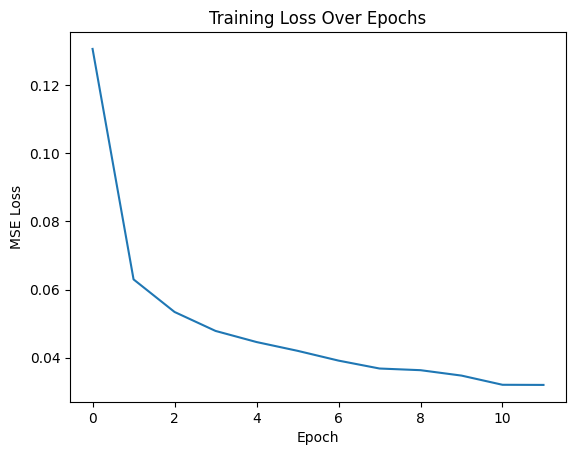

In [15]:
import time
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_ema import ExponentialMovingAverage
from torch.cuda.amp import autocast, GradScaler
import os
import numpy as np

# Record start time
start_time = time.time()

# Training configuration
num_epochs = 25  # Total epochs
start_epoch = 0  # Start from 0 unless resuming
checkpoint_path = None  # Set to load checkpoint if resuming

# Check for latest checkpoint
checkpoint_files = [f for f in os.listdir() if f.startswith("checkpoint_epoch_") and f.endswith(".pt")]
if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.split("_")[2].split(".")[0]))
    checkpoint_epoch = int(latest_checkpoint.split("_")[2].split(".")[0])
    checkpoint_path = latest_checkpoint
    ema_checkpoint_path = f"ema_{latest_checkpoint}"
    if os.path.exists(ema_checkpoint_path):
        print(f"Found checkpoint: {checkpoint_path} (epoch {checkpoint_epoch})")
        nets.load_state_dict(torch.load(checkpoint_path))
        ema.load_state_dict(torch.load(ema_checkpoint_path))
        start_epoch = checkpoint_epoch
        print(f"Resuming training from epoch {start_epoch + 1}")
    else:
        print(f"EMA checkpoint {ema_checkpoint_path} not found, starting fresh")
        checkpoint_path = None

# Initialize EMA, optimizer, scheduler, and scaler
ema = ExponentialMovingAverage(nets.parameters(), decay=0.75)
optimizer = torch.optim.AdamW(params=nets.parameters(), lr=1e-4, weight_decay=1e-6)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(dataloader) * num_epochs, eta_min=0)
scaler = GradScaler()  # For mixed precision training

# Load or initialize loss history
epoch_losses = torch.load("epoch_losses.pt") if os.path.exists("epoch_losses.pt") and checkpoint_path else []

# Print initial GPU memory stats
if torch.cuda.is_available():
    print("Initial GPU Memory Allocated:", torch.cuda.memory_allocated() / 1024**2, "MB")
    print("Initial GPU Memory Cached:", torch.cuda.memory_reserved() / 1024**2, "MB")

# Training loop
with tqdm(range(start_epoch, num_epochs), desc='Epoch') as tglobal:
    for epoch_idx in tglobal:
        epoch_loss = []
        with tqdm(dataloader, desc='Batch', leave=False) as tepoch:
            for nbatch in tepoch:
                nimage = nbatch['image'][:, :obs_horizon].to(device)
                nagent_pos = nbatch['agent_pos'][:, :obs_horizon].to(device)
                naction = nbatch['action'].to(device)
                B = nagent_pos.shape[0]

                # Debug: Print batch shapes
                print(f"Batch shapes: image={nimage.shape}, agent_pos={nagent_pos.shape}, action={naction.shape}")

                # Process observations with mixed precision
                with autocast():
                    image_features = nets['vision_encoder'](nimage.flatten(end_dim=1))
                    image_features = image_features.reshape(*nimage.shape[:2], -1)
                    obs_features = torch.cat([image_features, nagent_pos], dim=-1)
                    obs_cond = obs_features.flatten(start_dim=1)

                    # Add noise to actions
                    noise = torch.randn(naction.shape, device=device)
                    timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (B,), device=device).long()
                    noisy_actions = noise_scheduler.add_noise(naction, noise, timesteps)

                    # Transpose noisy_actions to [B, action_dim, pred_horizon]
                    noisy_actions = noisy_actions.permute(0, 2, 1)

                    # Predict noise
                    noise_pred = nets['noise_pred_net'](noisy_actions, timesteps, global_cond=obs_cond)
                    loss = nn.functional.mse_loss(noise_pred, noise.permute(0, 2, 1))

                # Backprop with mixed precision
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                lr_scheduler.step()
                ema.update()
                epoch_loss.append(loss.item())
                tepoch.set_postfix(loss=loss.item())

        # Compute and log epoch loss
        epoch_losses.append(np.mean(epoch_loss))
        tglobal.set_postfix(loss=np.mean(epoch_loss))

        # Checkpoint every 10 epochs
        if (epoch_idx + 1) % 10 == 0:
            torch.save(nets.state_dict(), f"checkpoint_epoch_{epoch_idx+1}.pt")
            torch.save(ema.state_dict(), f"ema_checkpoint_epoch_{epoch_idx+1}.pt")
            torch.save(epoch_losses, "epoch_losses.pt")  # Save loss history
            print(f"Saved checkpoint at epoch {epoch_idx+1}")

        # Early stopping
        if epoch_idx > 10 and epoch_losses[-1] < 0.05 and abs(epoch_losses[-1] - epoch_losses[-2]) < 1e-4:
            print(f"Early stopping at epoch {epoch_idx+1}: loss={epoch_losses[-1]}")
            break

# Apply EMA parameters
ema_nets = nets
ema.copy_to(ema_nets.parameters())

# Print training duration and final GPU memory stats
end_time = time.time()
print(f"Training time: {(end_time - start_time) / 3600:.2f} hours")

if torch.cuda.is_available():
    print("Final GPU Memory Allocated:", torch.cuda.memory_allocated() / 1024**2, "MB")
    print("Final GPU Memory Cached:", torch.cuda.memory_reserved() / 1024**2, "MB")

# Plot and save loss
plt.plot(epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.savefig('training_loss.png')
plt.show()

In [39]:
from gym import spaces
from tqdm import tqdm
import numpy as np
import torch
import collections
import skvideo.io
from IPython.display import Video
import pymunk.pygame_util

# inference
max_steps = 200
env = PushTImageEnv()
env.seed(100000)
obs, info = env.reset()
obs_deque = collections.deque([obs] * obs_horizon, maxlen=obs_horizon)
imgs = [env.render(mode='rgb_array')]
rewards = []
done = False
step_idx = 0

# Ensure models are on device
ema_nets['vision_encoder'] = ema_nets['vision_encoder'].to(device)
ema_nets['noise_pred_net'] = ema_nets['noise_pred_net'].to(device)

with tqdm(total=max_steps, desc="Eval PushTImageEnv") as pbar:
    while not done:
        B = 1
        images = np.stack([x['image'] for x in obs_deque])
        agent_poses = np.stack([x['agent_pos'] for x in obs_deque])
        nagent_poses = normalize_data(agent_poses, stats=stats['agent_pos'])
        nimages = torch.from_numpy(images).to(device, dtype=torch.float32)
        nagent_poses = torch.from_numpy(nagent_poses).to(device, dtype=torch.float32)
        with torch.no_grad():
            image_features = ema_nets['vision_encoder'](nimages)
            obs_features = torch.cat([image_features, nagent_poses], dim=-1)
            obs_cond = obs_features.unsqueeze(0).flatten(start_dim=1)
            noisy_action = torch.randn((B, pred_horizon, action_dim), device=device)
            naction = noisy_action
            noise_scheduler.set_timesteps(num_diffusion_iters, device=device)
            for k in noise_scheduler.timesteps:
                k_tensor = k.unsqueeze(0) if not isinstance(k, torch.Tensor) or k.dim() == 0 else k
                k_tensor = k_tensor.to(device)
                naction_transposed = naction.transpose(1, 2)  # [1, 16, 2] -> [1, 2, 16]
                noise_pred = ema_nets['noise_pred_net'](naction_transposed, k_tensor, global_cond=obs_cond)
                noise_pred = noise_pred.transpose(1, 2)  # [1, 2, 16] -> [1, 16, 2]
                naction = noise_scheduler.step(model_output=noise_pred, timestep=k, sample=naction).prev_sample
        naction = naction.detach().cpu().numpy()[0]
        action_pred = unnormalize_data(naction, stats=stats['action'])
        start = obs_horizon - 1
        end = start + action_horizon
        action = action_pred[start:end, :]
        for i in range(len(action)):
            obs, reward, done, _, info = env.step(action[i])
            obs_deque.append(obs)
            rewards.append(reward)
            imgs.append(env.render(mode='rgb_array'))
            step_idx += 1
            pbar.update(1)
            pbar.set_postfix(reward=reward)
            if step_idx >= max_steps:
                done = True
            if done:
                break

print('Score: ', max(rewards))
skvideo.io.vwrite('vis.mp4', np.array(imgs))
Video('vis.mp4', embed=True, width=256, height=256)

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Unet input shape: torch.Size([1, 2, 16]), timesteps: torch.Size([1]), global_cond: torch.Size([1, 1028])
ConditionalResidualBlock1D input shape: torch.Size([1, 2, 16])
Conv1dBlock input shape: torch.Size([1, 2, 16])
Conv1dBlock output shape: torch.Size([1, 64, 16])
Conv1dBlock input shape: torch.Size([1, 64, 16])
Conv1dBlock output shape: torch.Size([1, 64, 16])
ConditionalResidualBlock1D output shape: torch.Size([1, 64, 16])
Down block 0 output shape: torch.Size([1, 64, 16])


TypeError: Downsample1d.forward() takes 2 positional arguments but 3 were given